In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
%matplotlib inline

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [3]:
confirmed_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,413,414,414,418,418,422,426,428,428,429
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,102,119,120,124,124,125


In [4]:
cols = confirmed_df.keys()

In [5]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [6]:

dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)

In [7]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [8]:
days_in_future = 5
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

In [9]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-5]

In [10]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.2, shuffle=False)

In [11]:
kernel = ['linear', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.1s finished
/Users/rakshithacharya/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [12]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'linear', 'gamma': 1, 'epsilon': 0.1, 'C': 10}

In [13]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 2767.0176470588253
MSE: 15956927.256505143


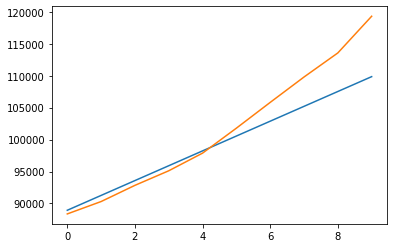

In [14]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [15]:
linear_model = LinearRegression(fit_intercept=False, normalize=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = list(linear_model.predict(future_forcast))
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 4258.218034596993
MSE: 22778055.000724956


In [16]:
linear_model = LinearRegression(fit_intercept=False, normalize=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = list(linear_model.predict(future_forcast))
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 4258.218034596993
MSE: 22778055.000724956


In [17]:
linear_model.coef_

array([[2414.85787896]])

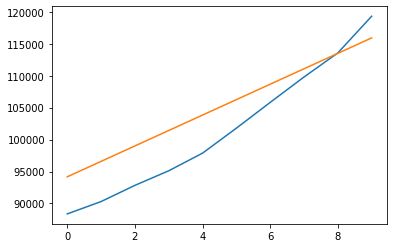

In [18]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

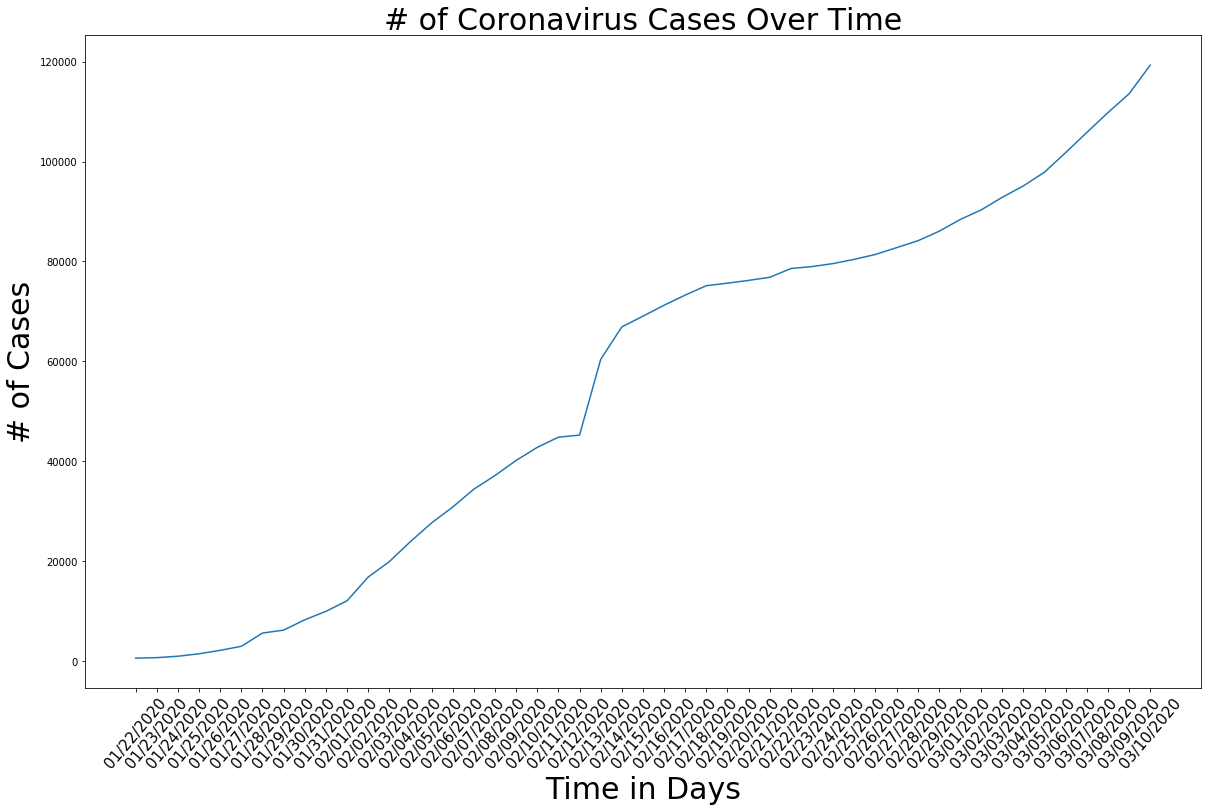

In [19]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

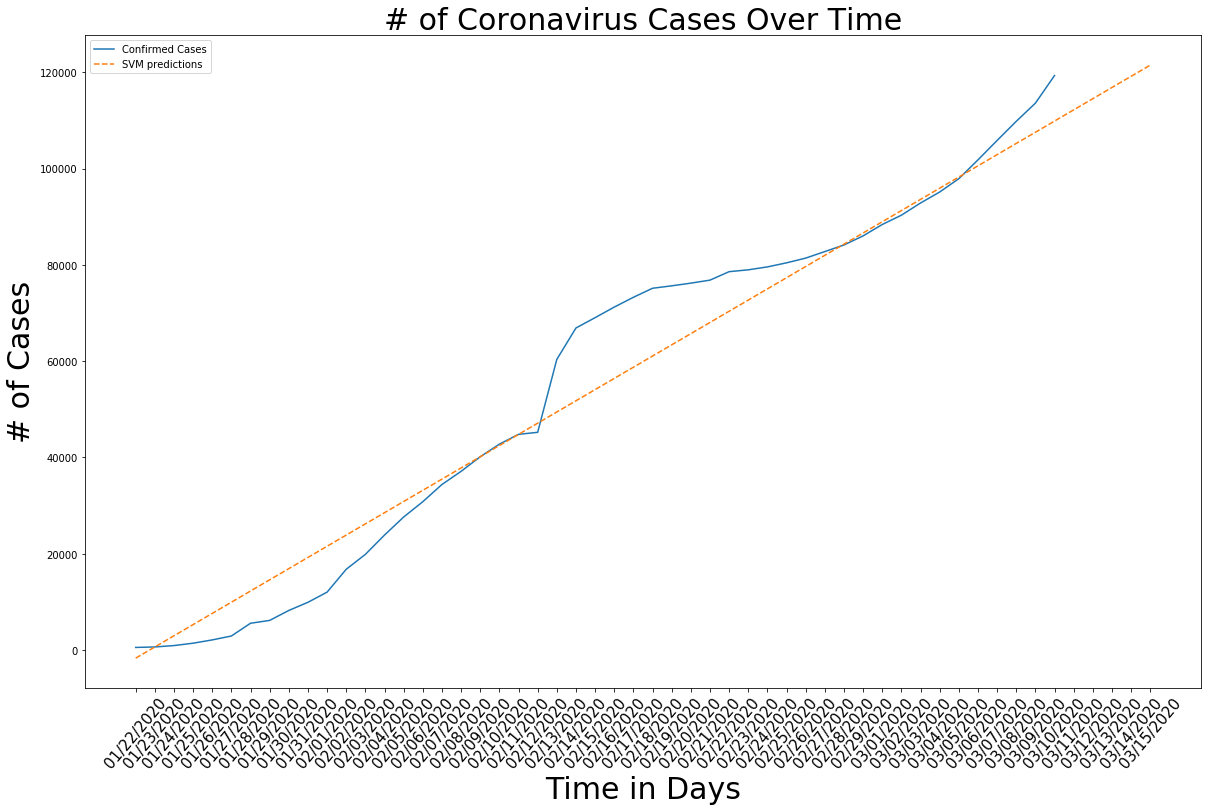

In [20]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, svm_pred, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

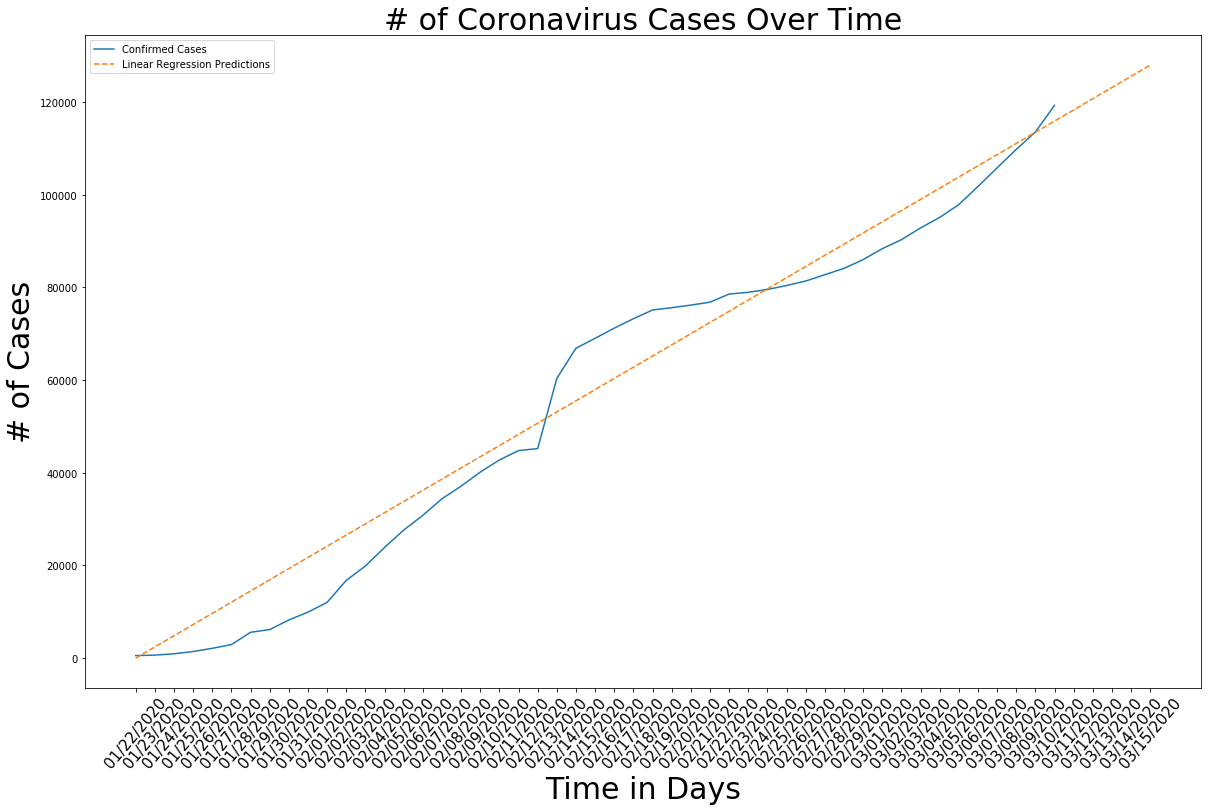

In [21]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, linear_pred, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(rotation=50, size=15)
plt.show()


In [22]:
print('SVM future predictions:')
for i in set(zip(future_forcast_dates[-5:], svm_pred[-5:])):
    print(i)

SVM future predictions:
('03/11/2020', 112173.84117647058)
('03/14/2020', 119143.90000000001)
('03/15/2020', 121467.25294117648)
('03/13/2020', 116820.54705882353)
('03/12/2020', 114497.19411764709)


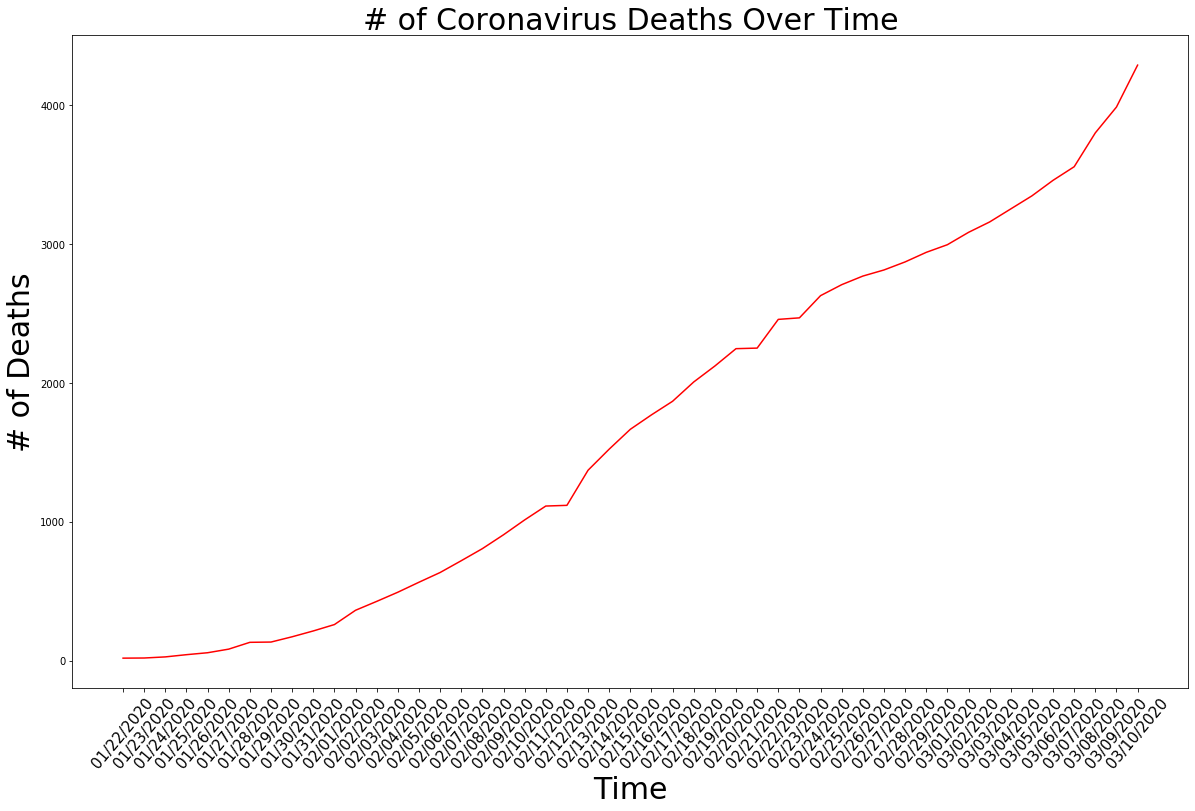

In [23]:

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

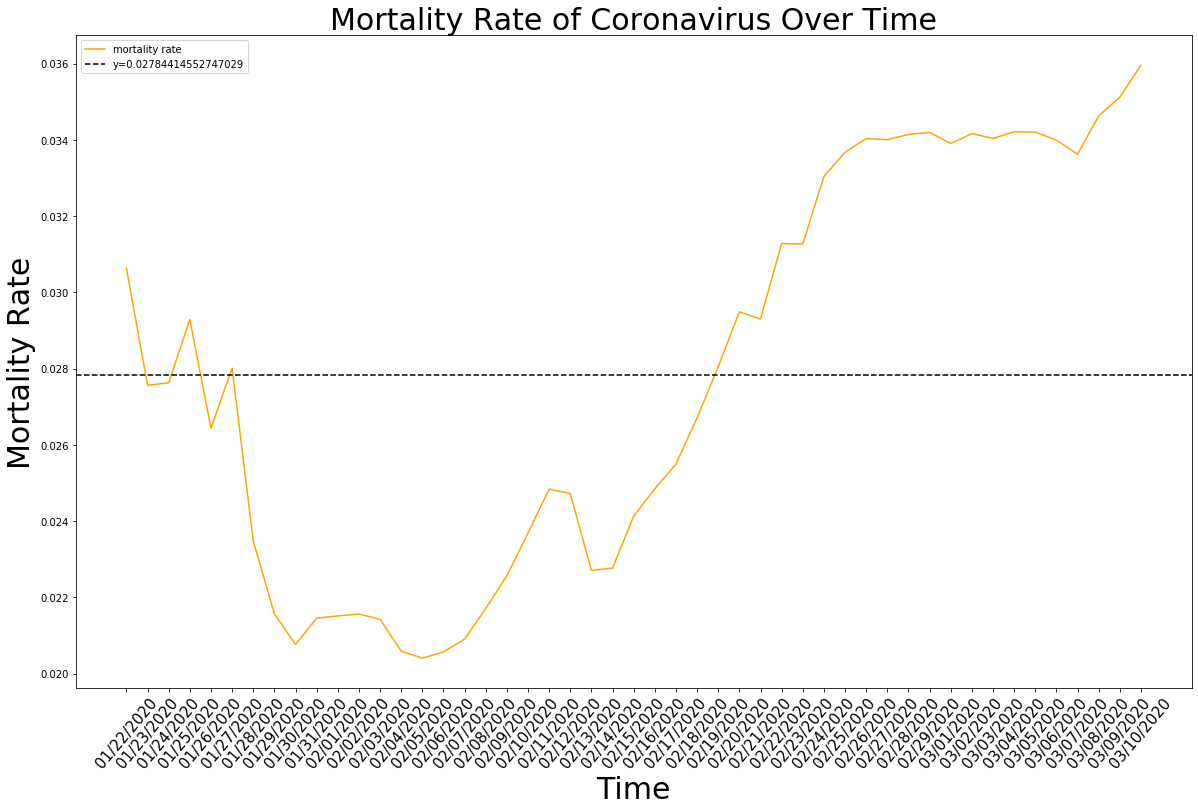

In [24]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)])
plt.xlabel('Time', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

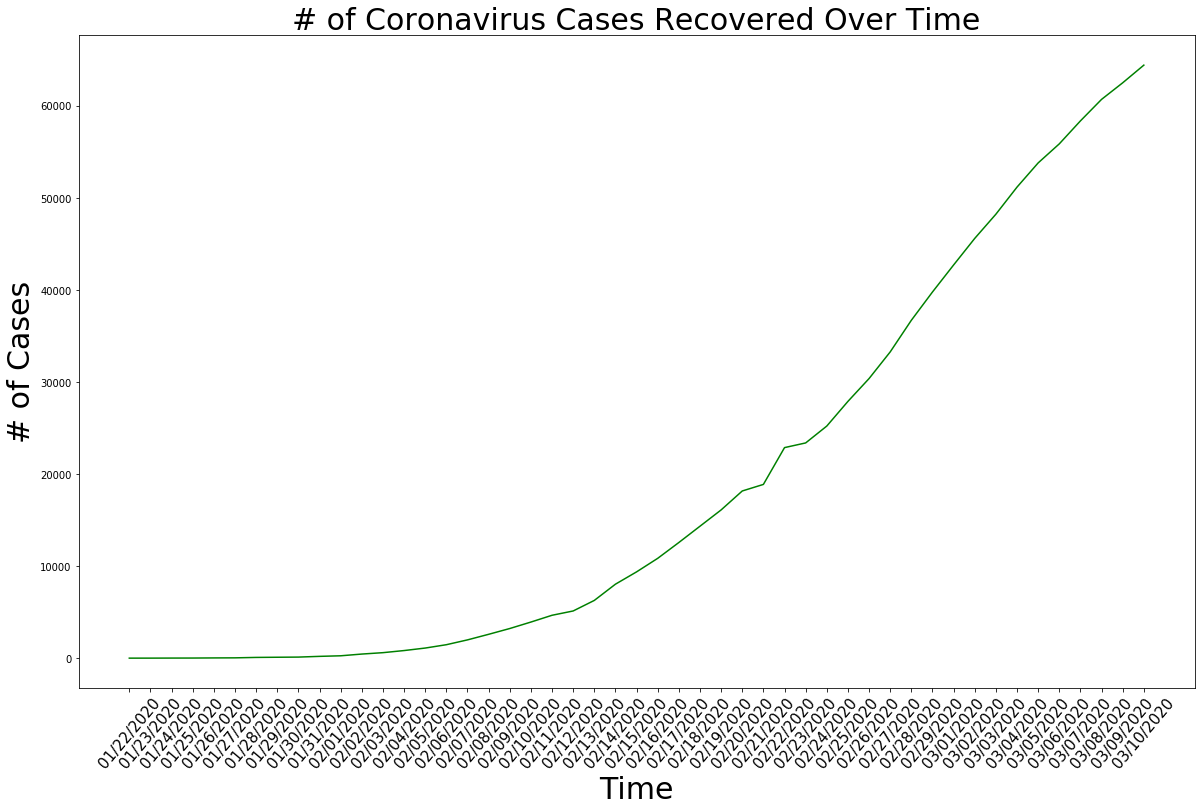

In [25]:

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

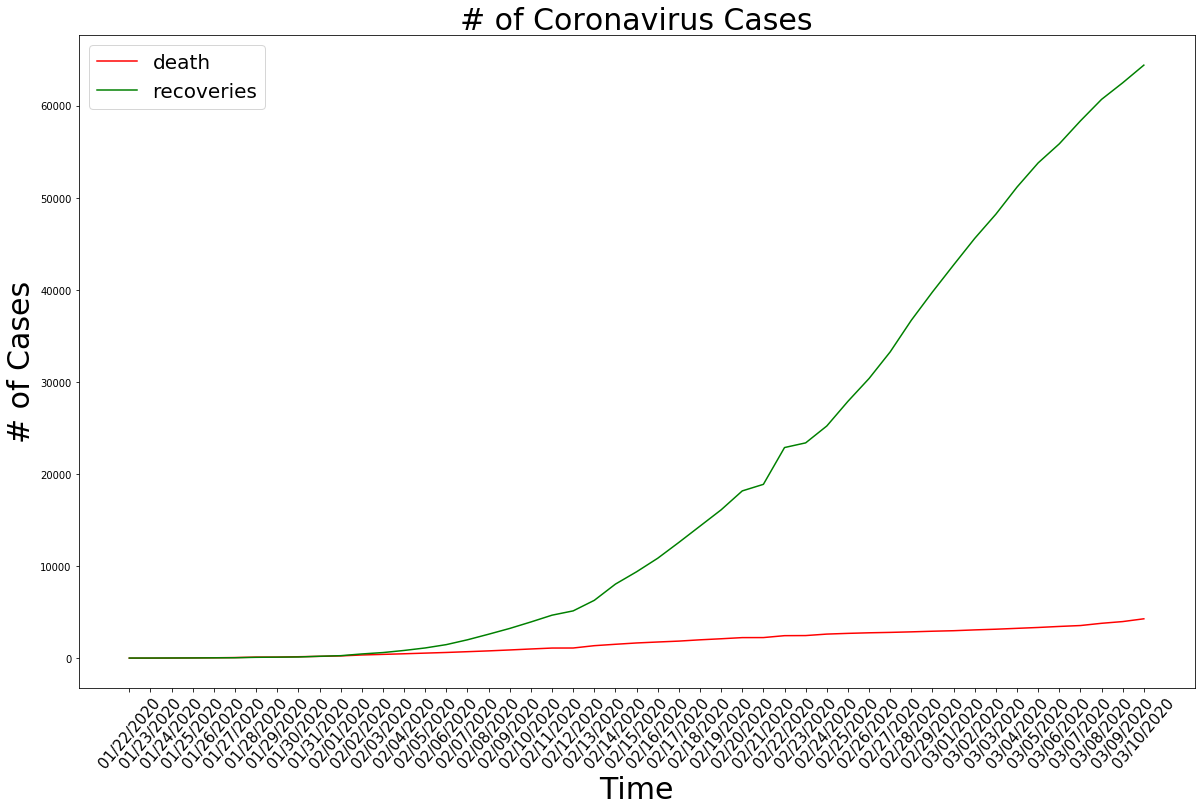

In [26]:

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

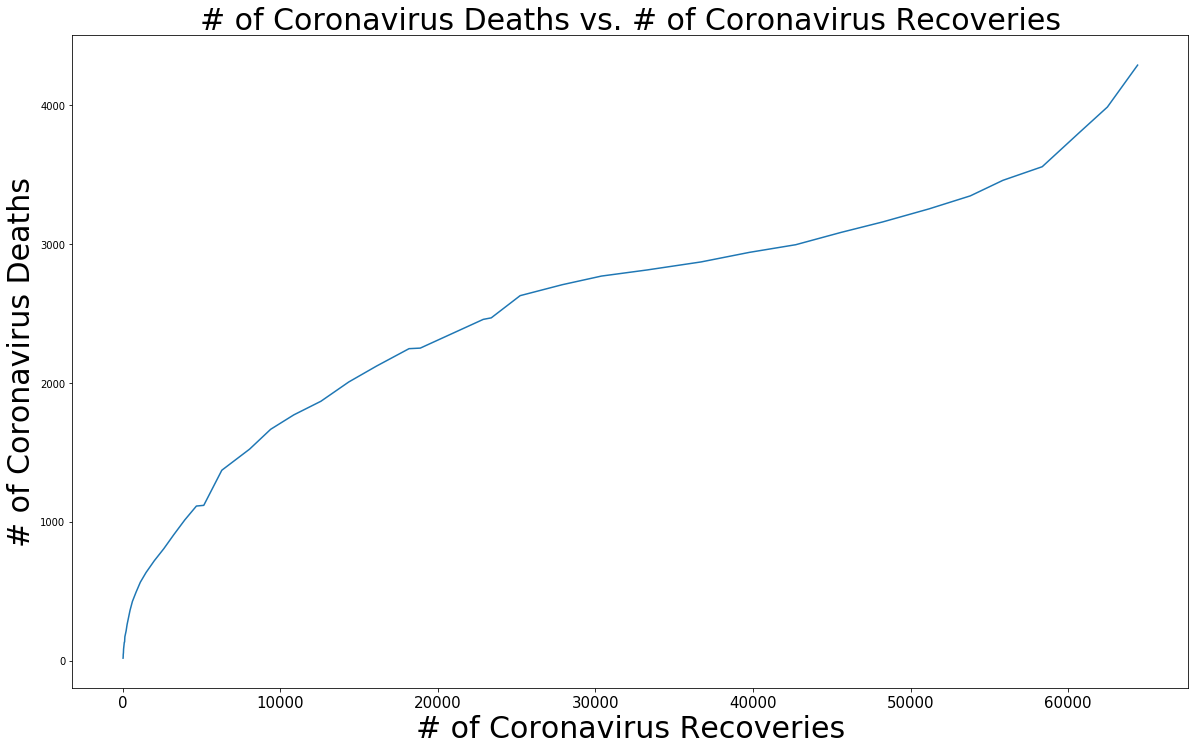

In [27]:
plt.figure(figsize=(20, 12))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=15)
plt.show()

In [28]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

In [29]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [30]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)

In [31]:
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Mainland China: 80757 cases
Thailand: 53 cases
Japan: 581 cases
US: 1670 cases
Singapore: 160 cases
France: 1784 cases
Nepal: 1 cases
Malaysia: 129 cases
Canada: 79 cases
Australia: 107 cases
Cambodia: 2 cases
Sri Lanka: 1 cases
Germany: 1457 cases
Finland: 40 cases
United Arab Emirates: 74 cases
Philippines: 33 cases
India: 56 cases
Italy: 10149 cases
UK: 382 cases
Sweden: 355 cases
Spain: 1695 cases
Belgium: 267 cases
Others: 696 cases
Egypt: 59 cases
Lebanon: 41 cases
Iraq: 71 cases
Oman: 18 cases
Afghanistan: 5 cases
Bahrain: 110 cases
Kuwait: 69 cases
Algeria: 20 cases
Croatia: 14 cases
Switzerland: 491 cases
Austria: 182 cases
Israel: 58 cases
Pakistan: 16 cases
Brazil: 31 cases
Georgia: 15 cases
Greece: 89 cases
North Macedonia: 7 cases
Norway: 400 cases
Romania: 25 cases
Denmark: 262 cases
Estonia: 12 cases
Netherlands: 382 cases
San Marino: 51 cases
Belarus: 9 cases
Iceland: 69 cases
Lithuania: 1 cases
Mexico: 7 cases
New Zealand: 5 cases
Nigeria: 2 cases
Ireland: 34 cases
Lux

In [32]:
unique_provinces =  list(confirmed_df['Province/State'].unique())

In [33]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)

In [34]:
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Anhui: 990 cases
Beijing: 429 cases
Chongqing: 576 cases
Fujian: 296 cases
Gansu: 125 cases
Guangdong: 1353 cases
Guangxi: 252 cases
Guizhou: 146 cases
Hainan: 168 cases
Hebei: 318 cases
Heilongjiang: 481 cases
Henan: 1272 cases
Hubei: 67760 cases
Hunan: 1018 cases
Inner Mongolia: 75 cases
Jiangsu: 631 cases
Jiangxi: 935 cases
Jilin: 93 cases
Liaoning: 125 cases
Ningxia: 75 cases
Qinghai: 18 cases
Shaanxi: 245 cases
Shandong: 758 cases
Shanghai: 344 cases
Shanxi: 133 cases
Sichuan: 539 cases
Tianjin: 136 cases
Tibet: 1 cases
Xinjiang: 76 cases
Yunnan: 174 cases
Zhejiang: 1215 cases
King County, WA: 116 cases
Cook County, IL: 11 cases
British Columbia: 32 cases
Los Angeles, CA: 20 cases
New South Wales: 55 cases
Victoria: 18 cases
Queensland: 18 cases
South Australia: 7 cases
San Benito, CA: 2 cases
Diamond Princess cruise ship: 696 cases
San Diego County, CA: 3 cases
Humboldt County, CA: 1 cases
Sacramento County, CA: 10 cases
Western Australia: 6 cases
Snohomish County, WA: 37 cases
T

In [35]:
nan_indices = []
# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

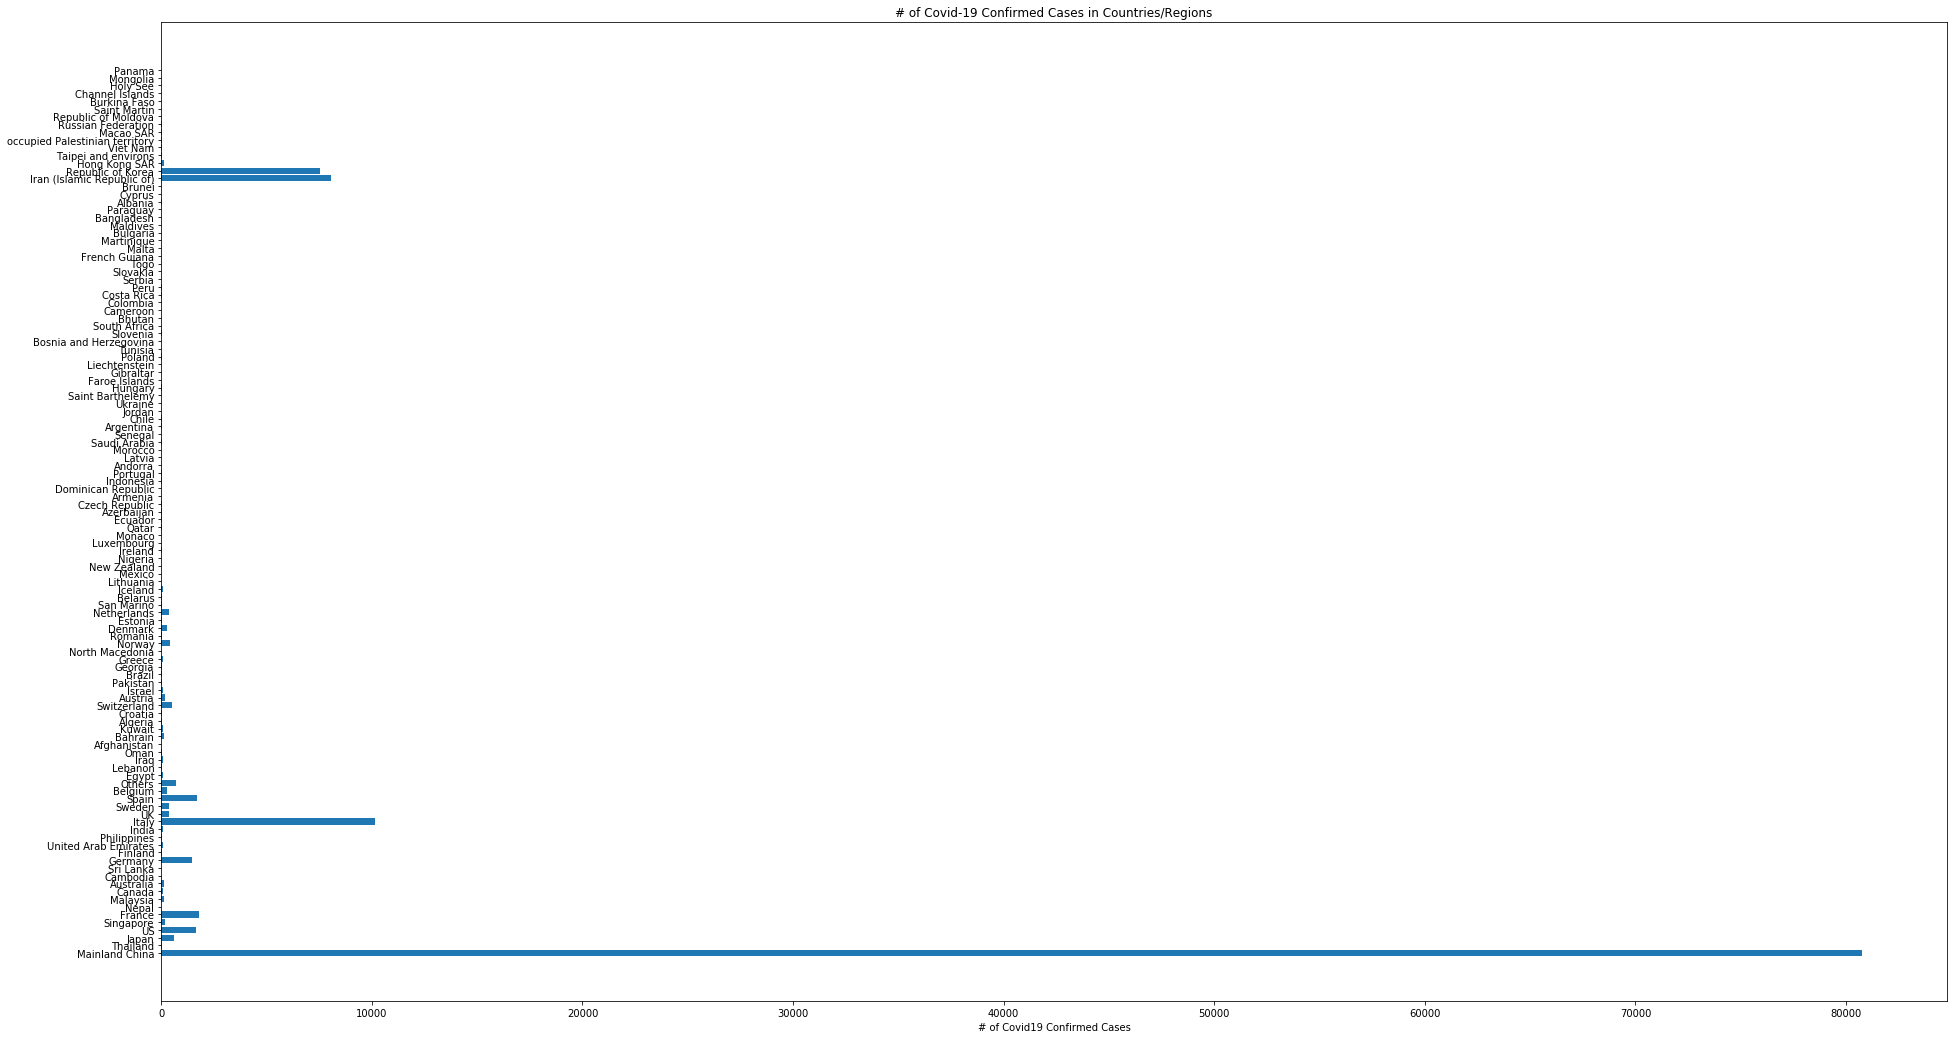

In [36]:

plt.figure(figsize=(32, 18))
plt.barh(unique_countries, country_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions')
plt.xlabel('# of Covid19 Confirmed Cases')
plt.show()

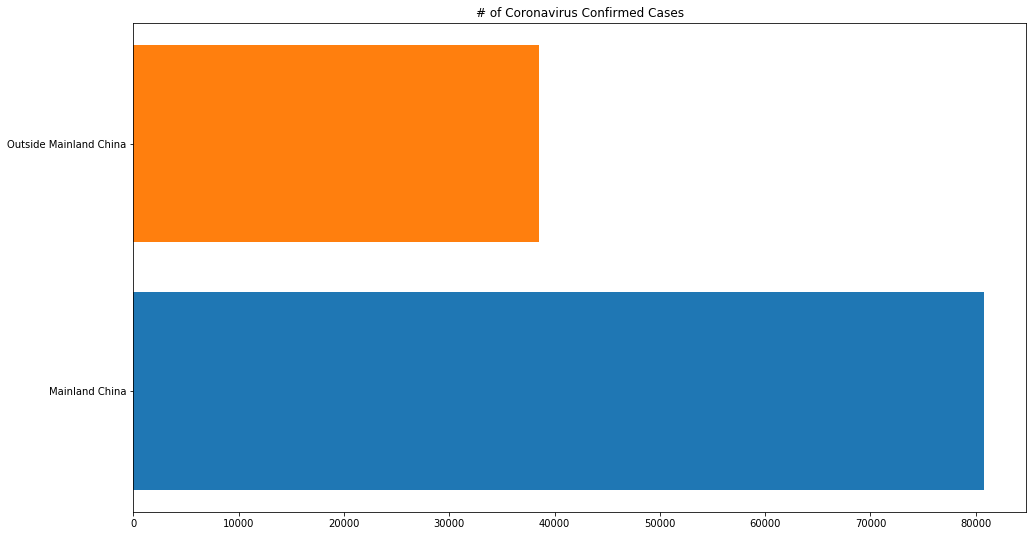

In [37]:

outside_mainland_china_confirmed = np.sum(country_confirmed_cases[1:])
plt.figure(figsize=(16, 9))
plt.barh(unique_countries[0], country_confirmed_cases[0])
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases')
plt.show()

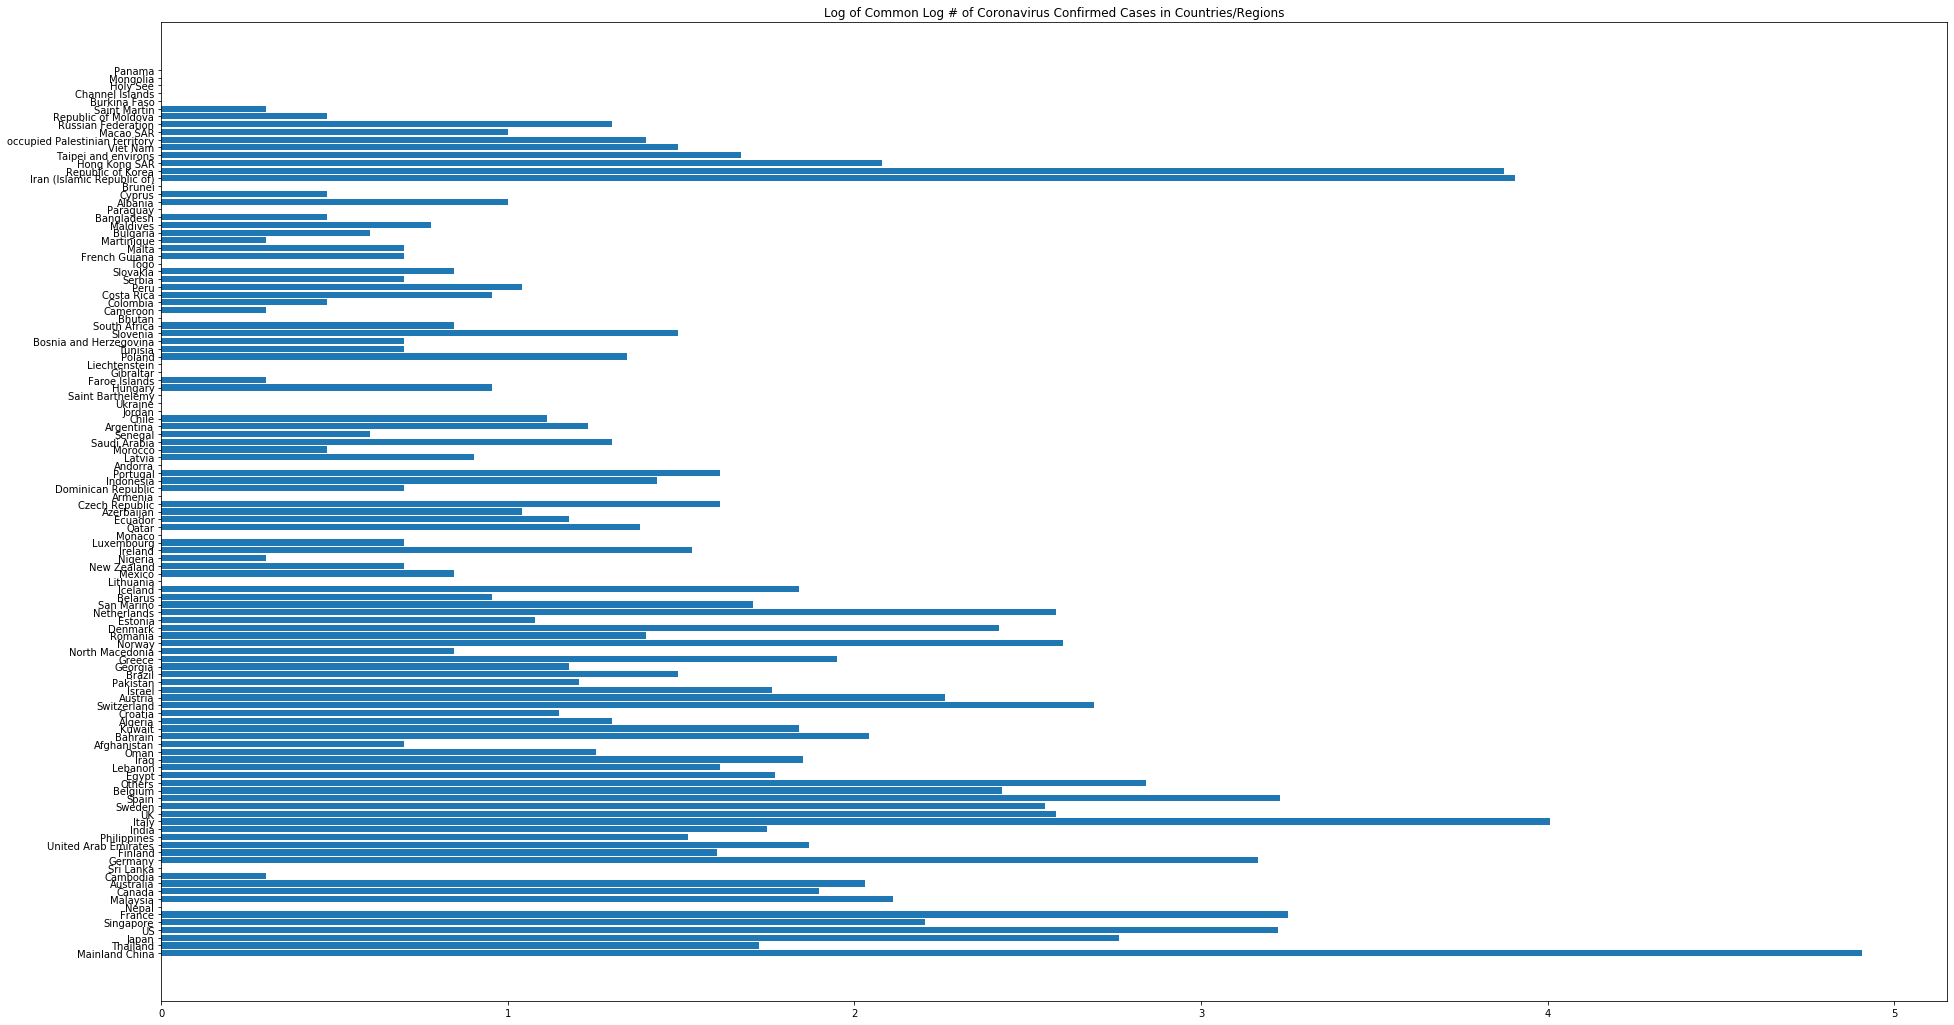

In [38]:
log_country_confirmed_cases = [math.log10(i) for i in country_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions')
plt.show()

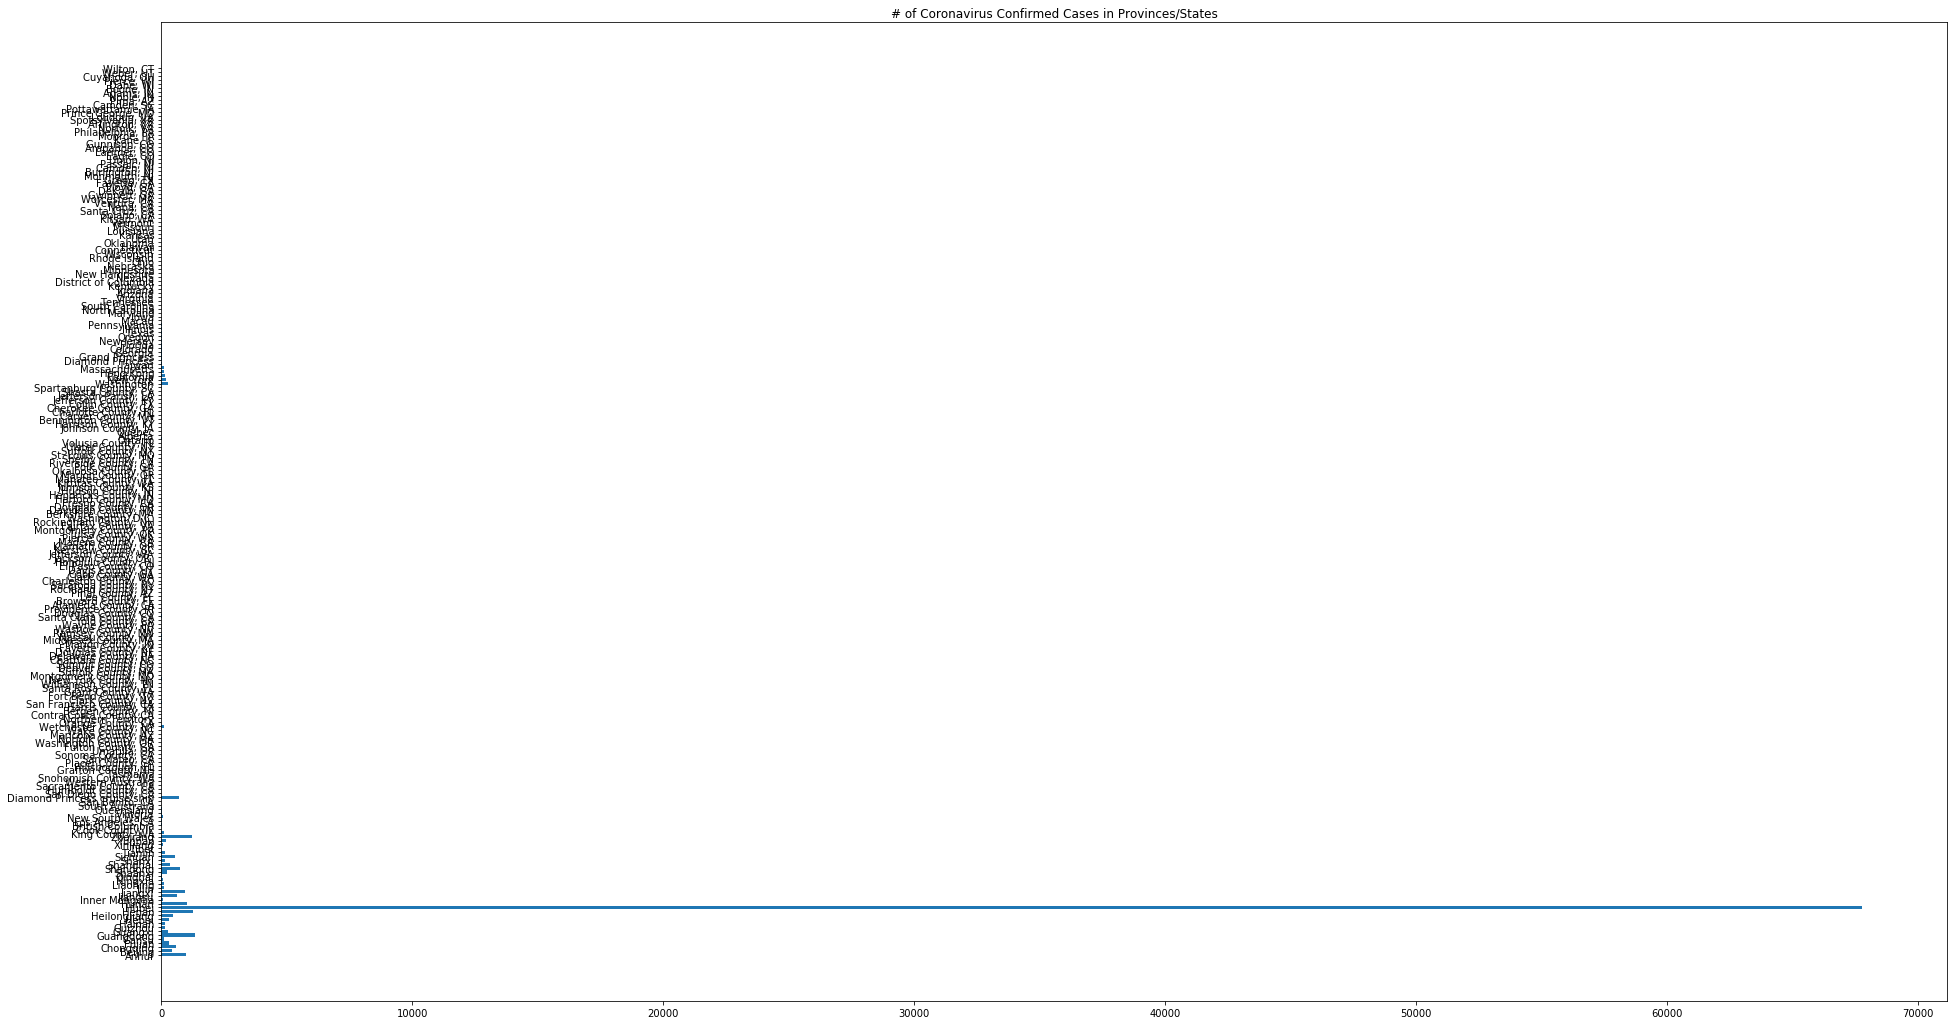

In [39]:
plt.figure(figsize=(32, 18))
plt.barh(unique_provinces, province_confirmed_cases)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States')
plt.show()

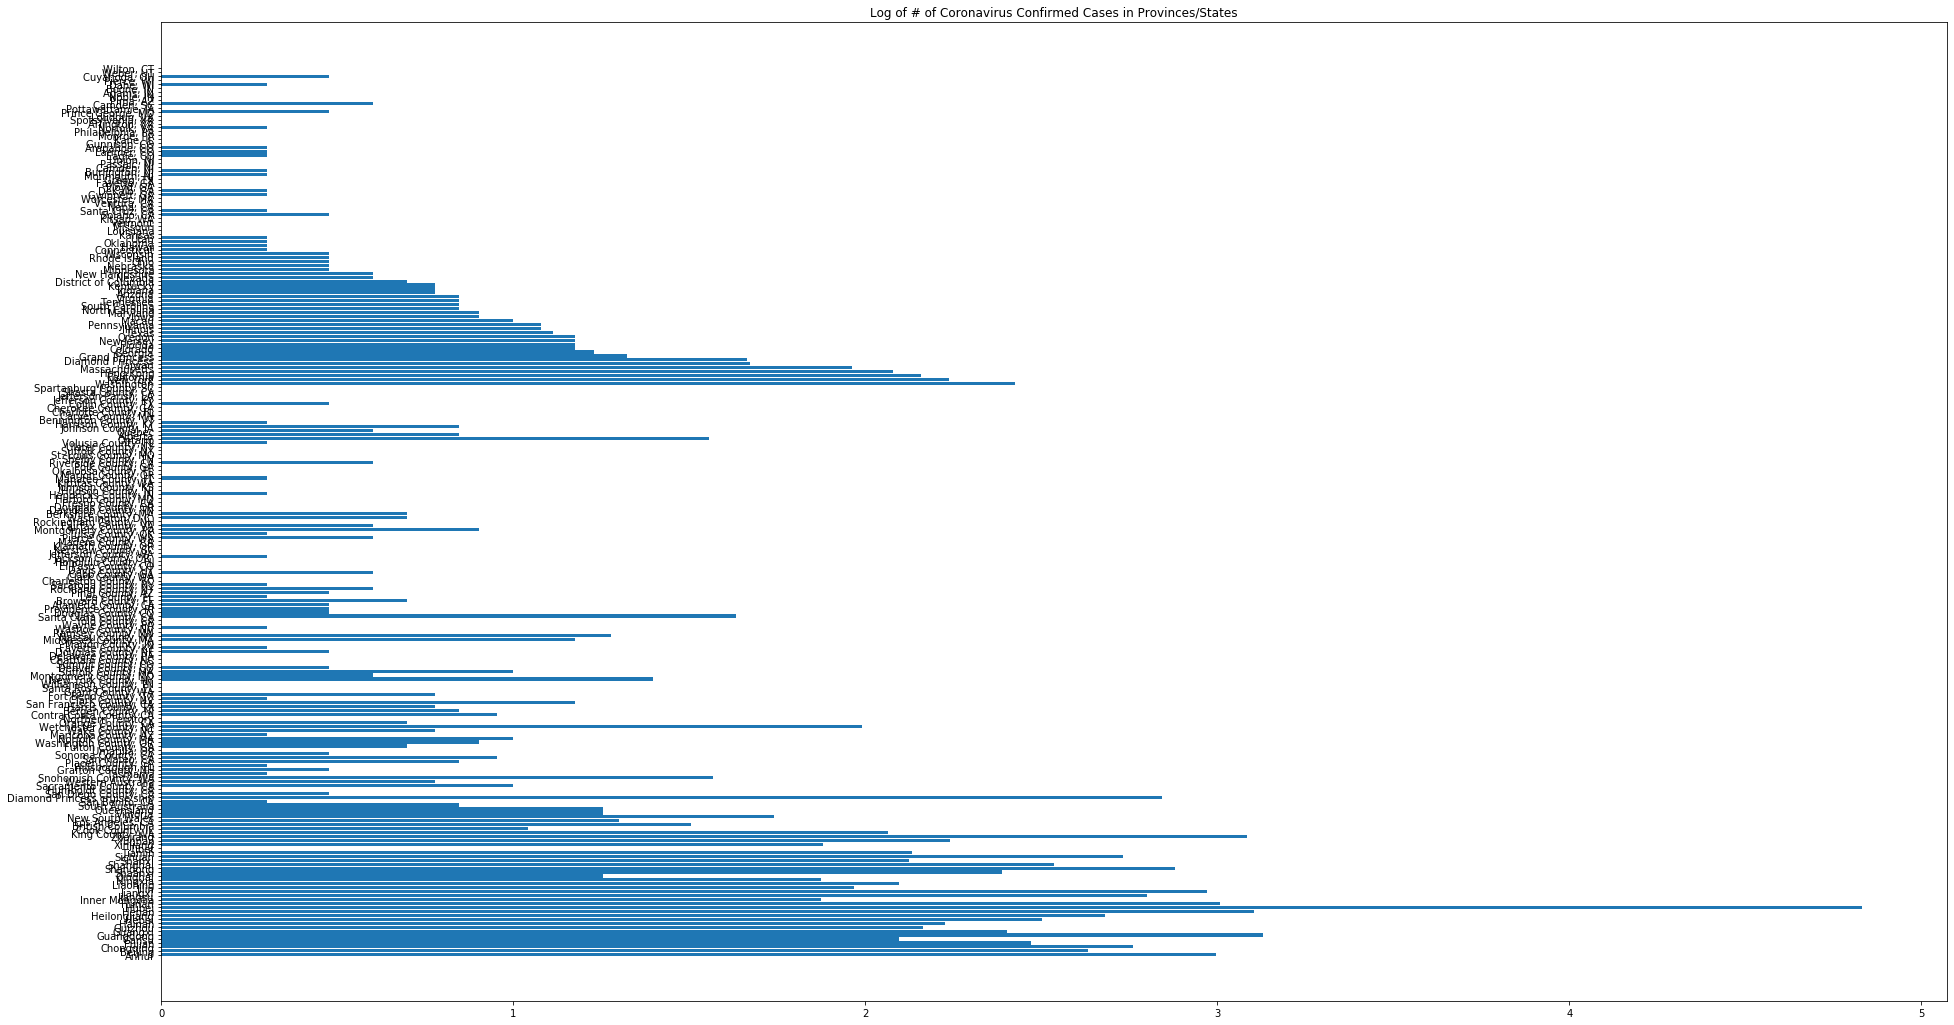

In [40]:
log_province_confirmed_cases = [math.log10(i) for i in province_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States')
plt.show()

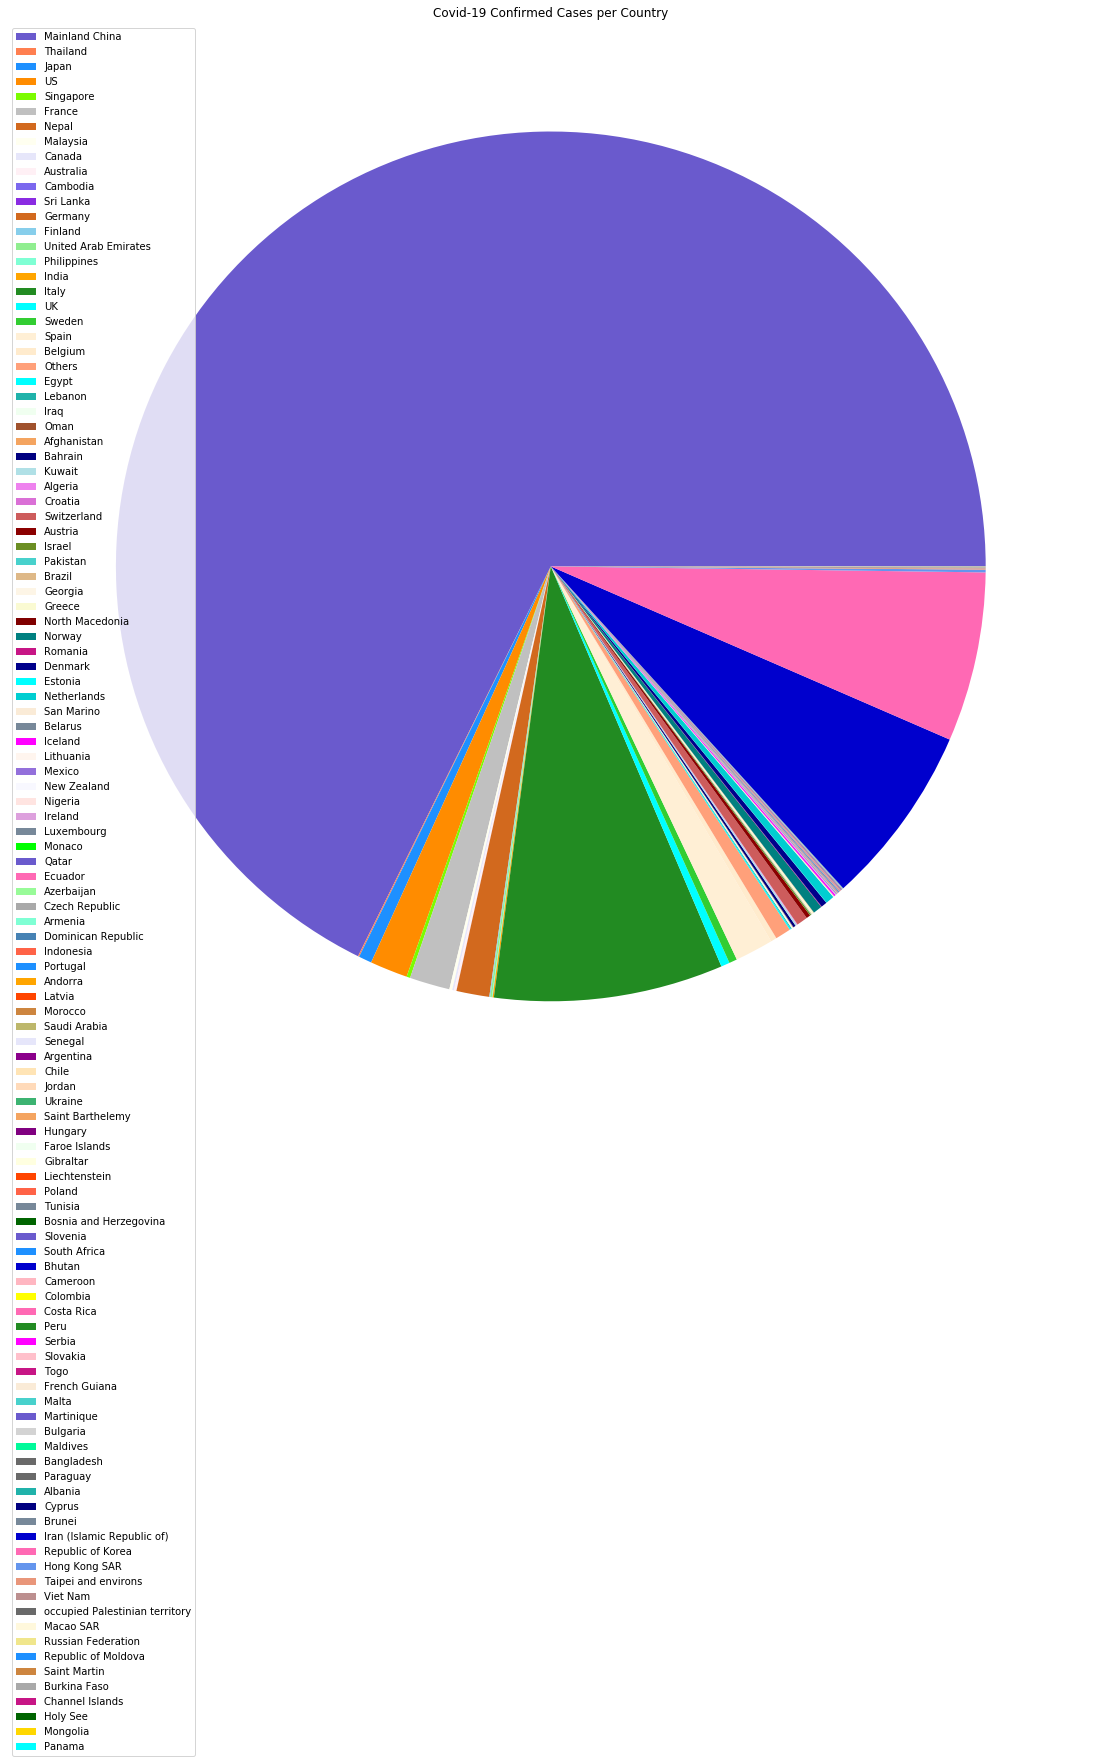

In [41]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country')
plt.pie(country_confirmed_cases, colors=c)
plt.legend(unique_countries, loc='best')
plt.show()

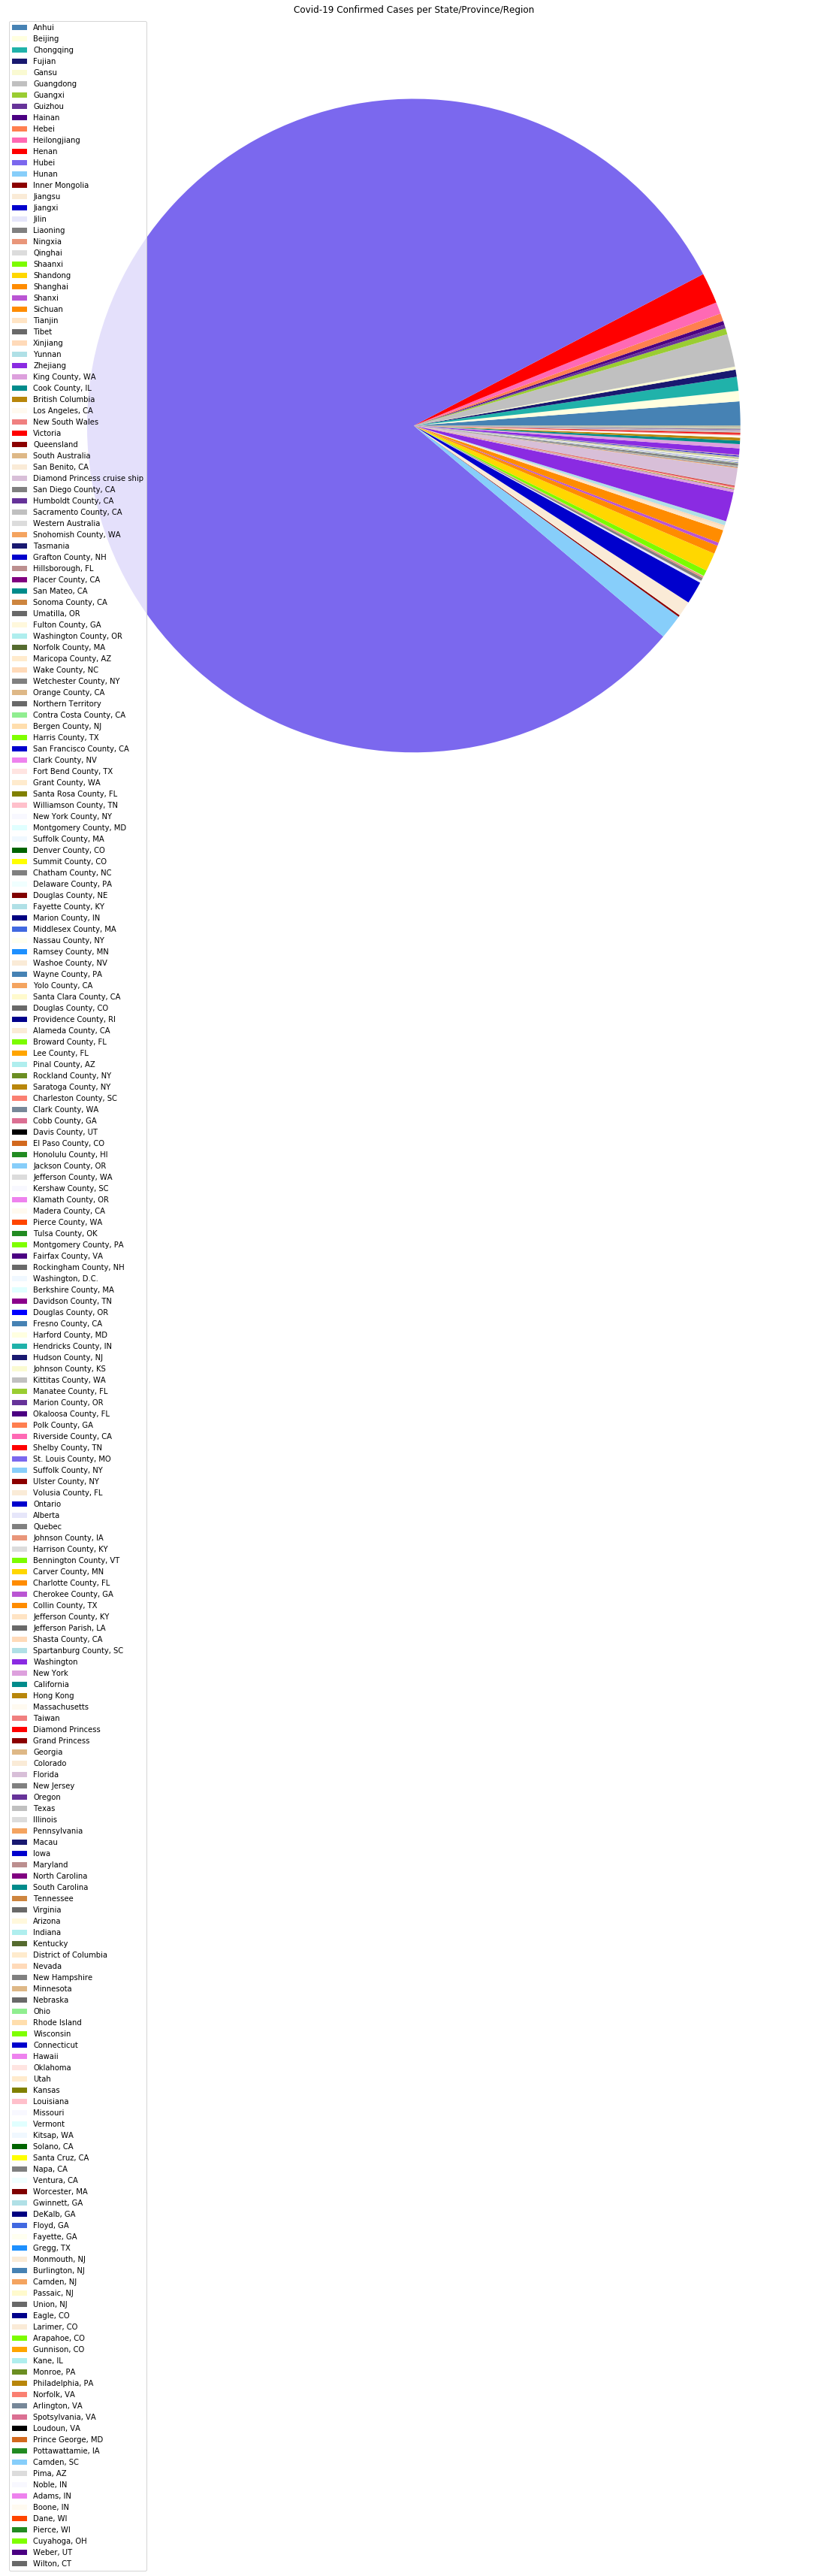

In [42]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per State/Province/Region')
plt.pie(province_confirmed_cases, colors=c)
plt.legend(unique_provinces, loc='best')
plt.show()

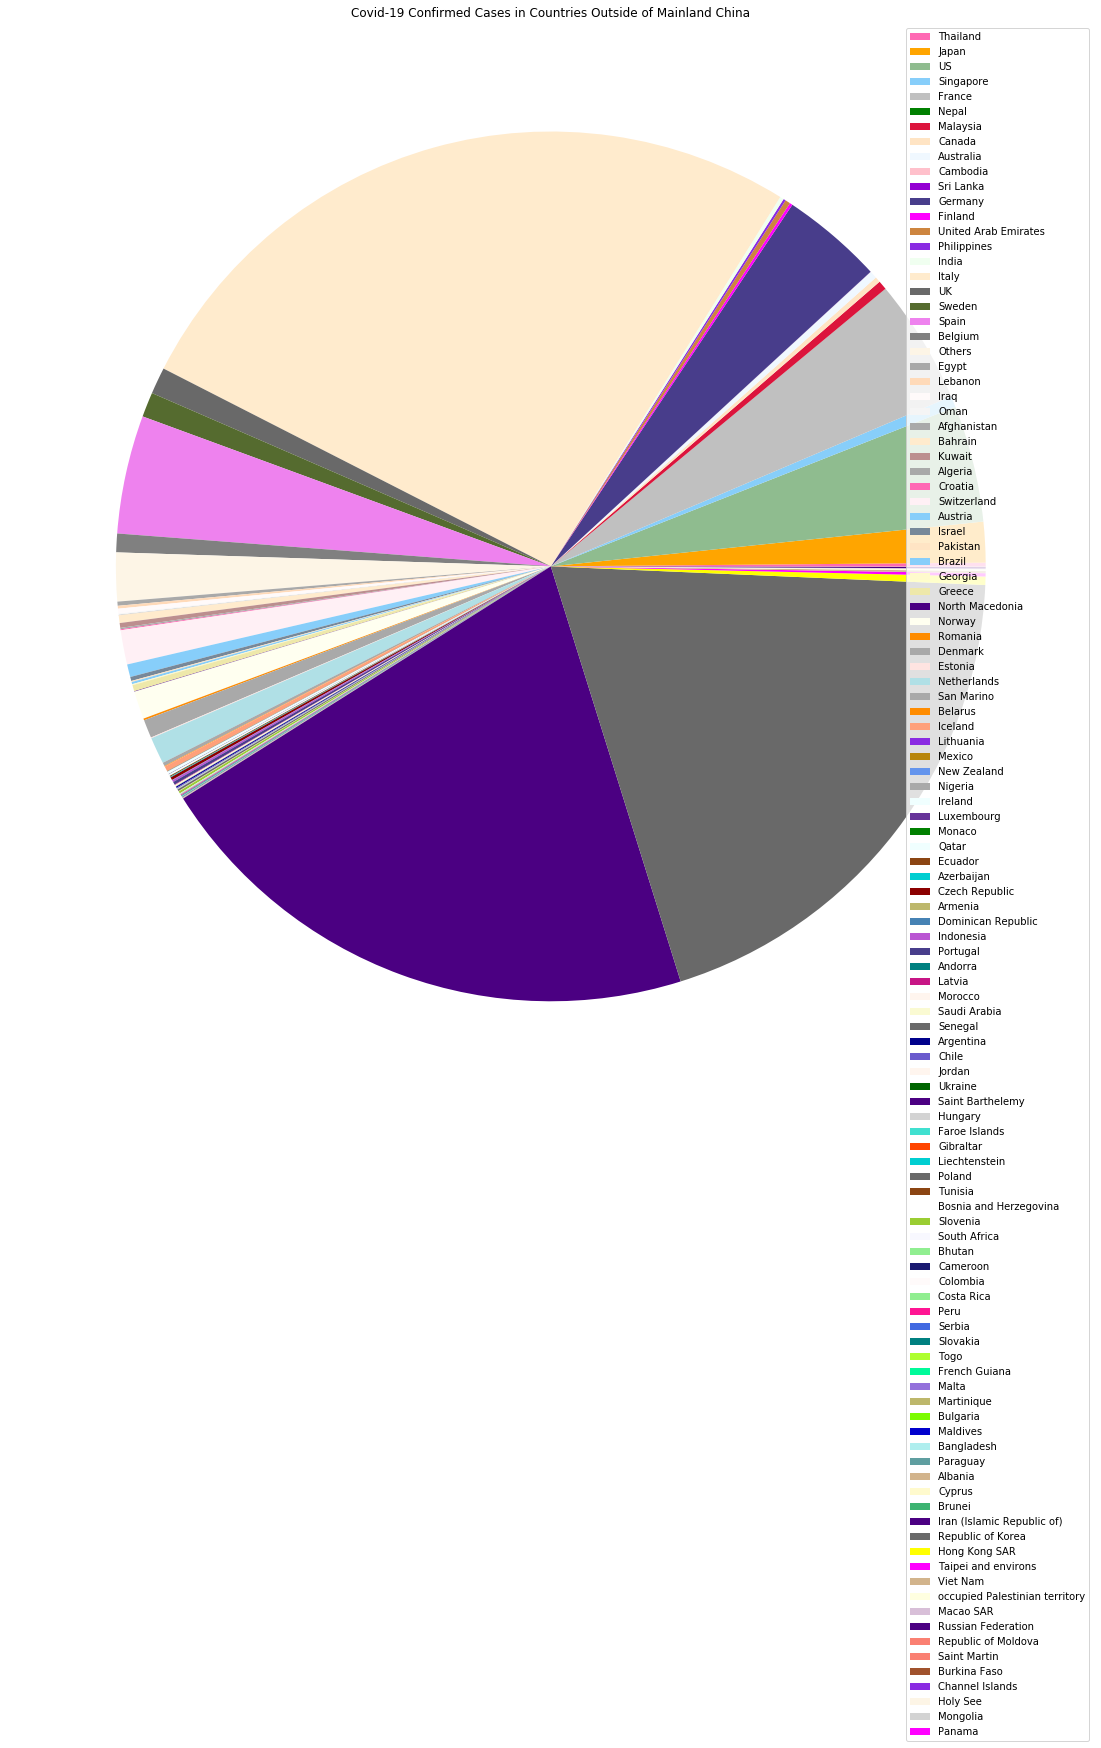

In [43]:

c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China')
plt.pie(country_confirmed_cases[1:], colors=c)
plt.legend(unique_countries[1:], loc='best')
plt.show()

In [44]:
us_regions = list(confirmed_df[confirmed_df['Country/Region']=='US']['Province/State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)

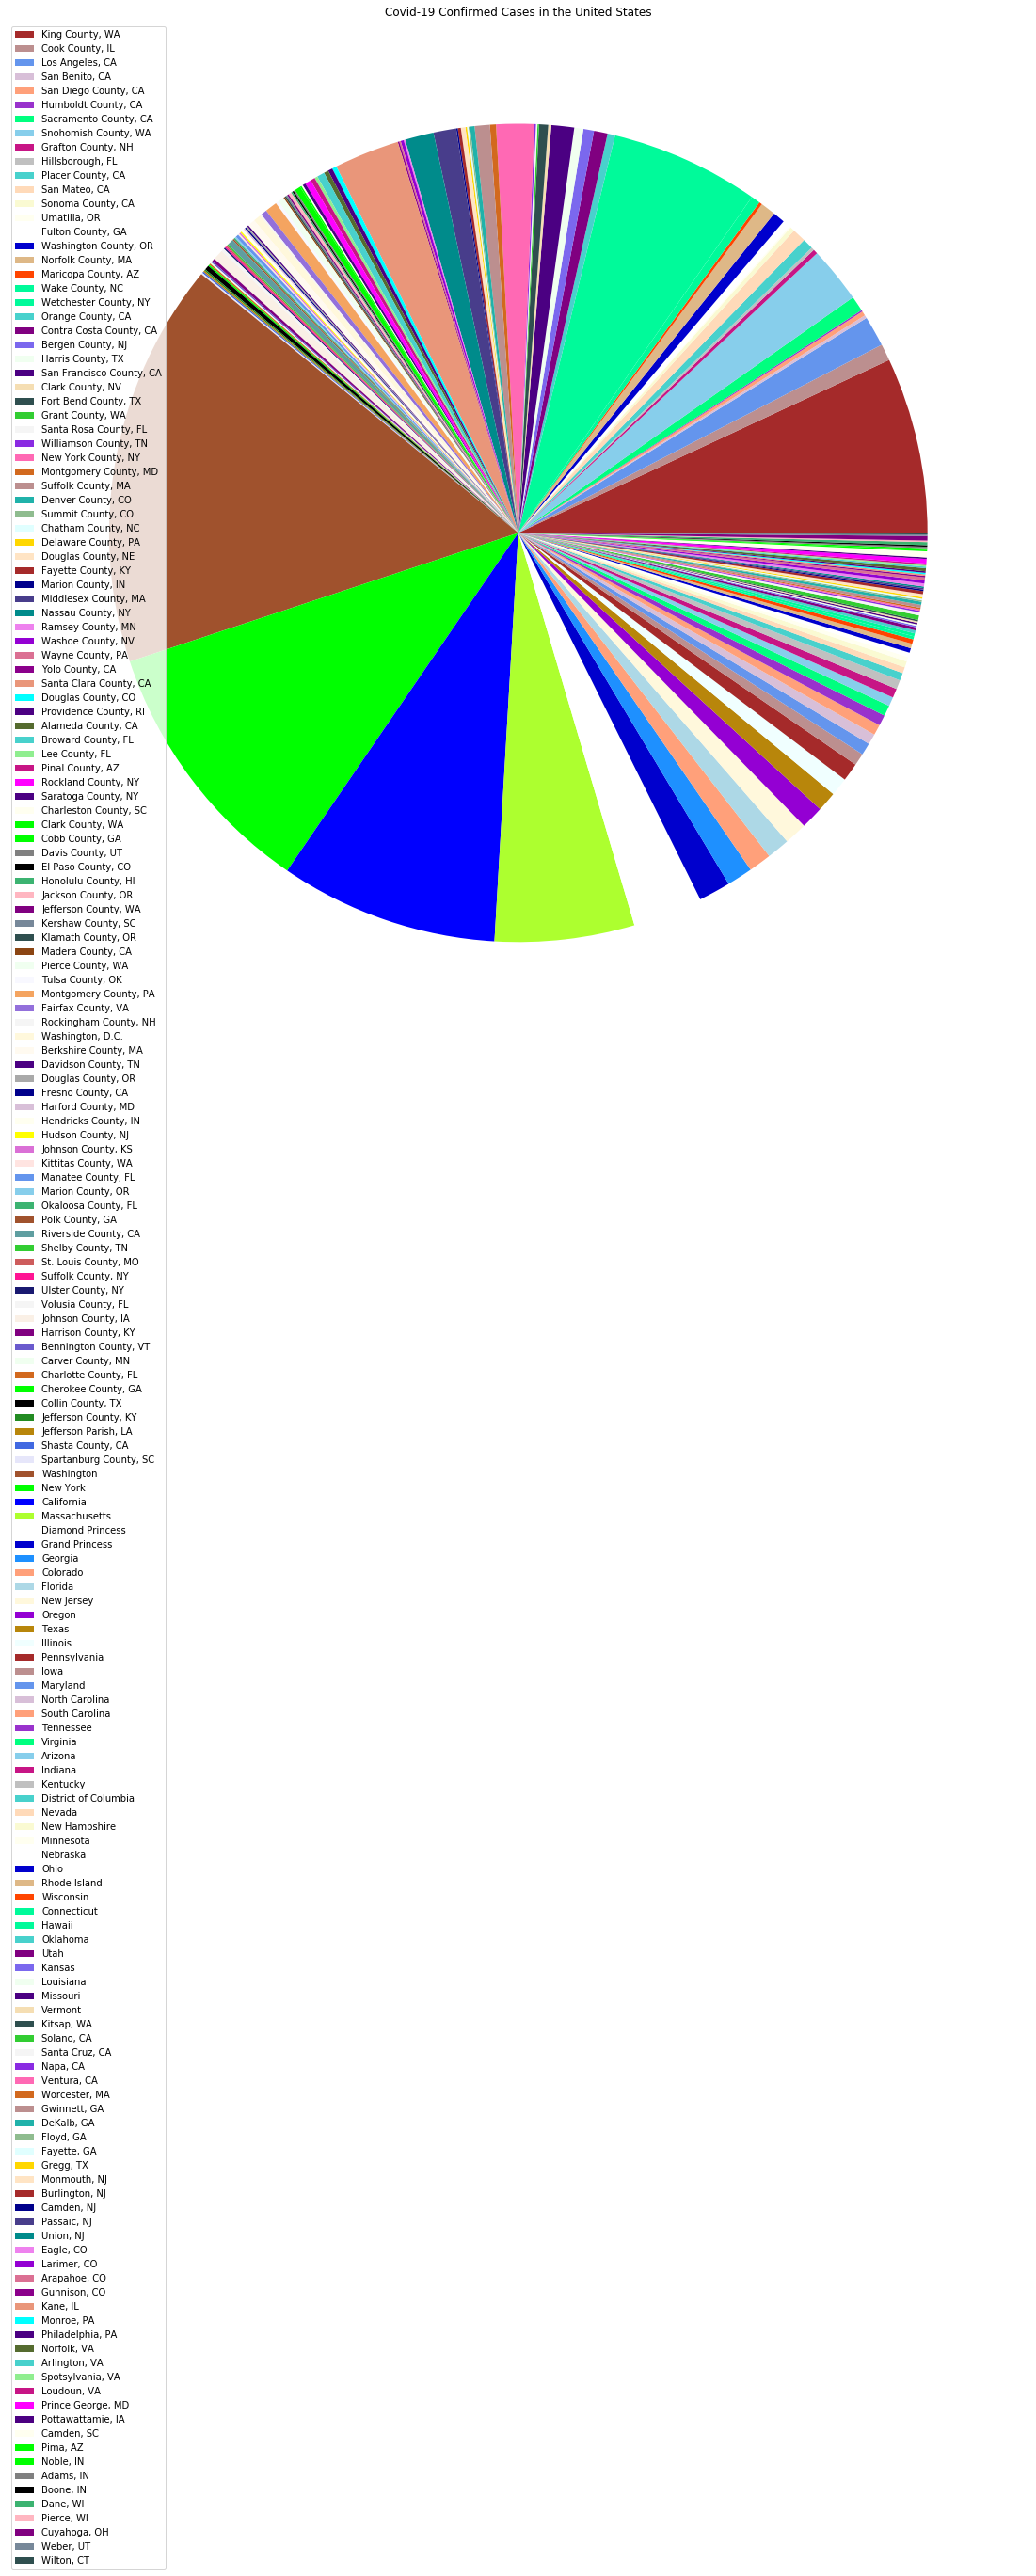

In [45]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the United States')
plt.pie(us_confirmed_cases, colors=c)
plt.legend(us_regions, loc='best')
plt.show()

In [46]:
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='Mainland China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)

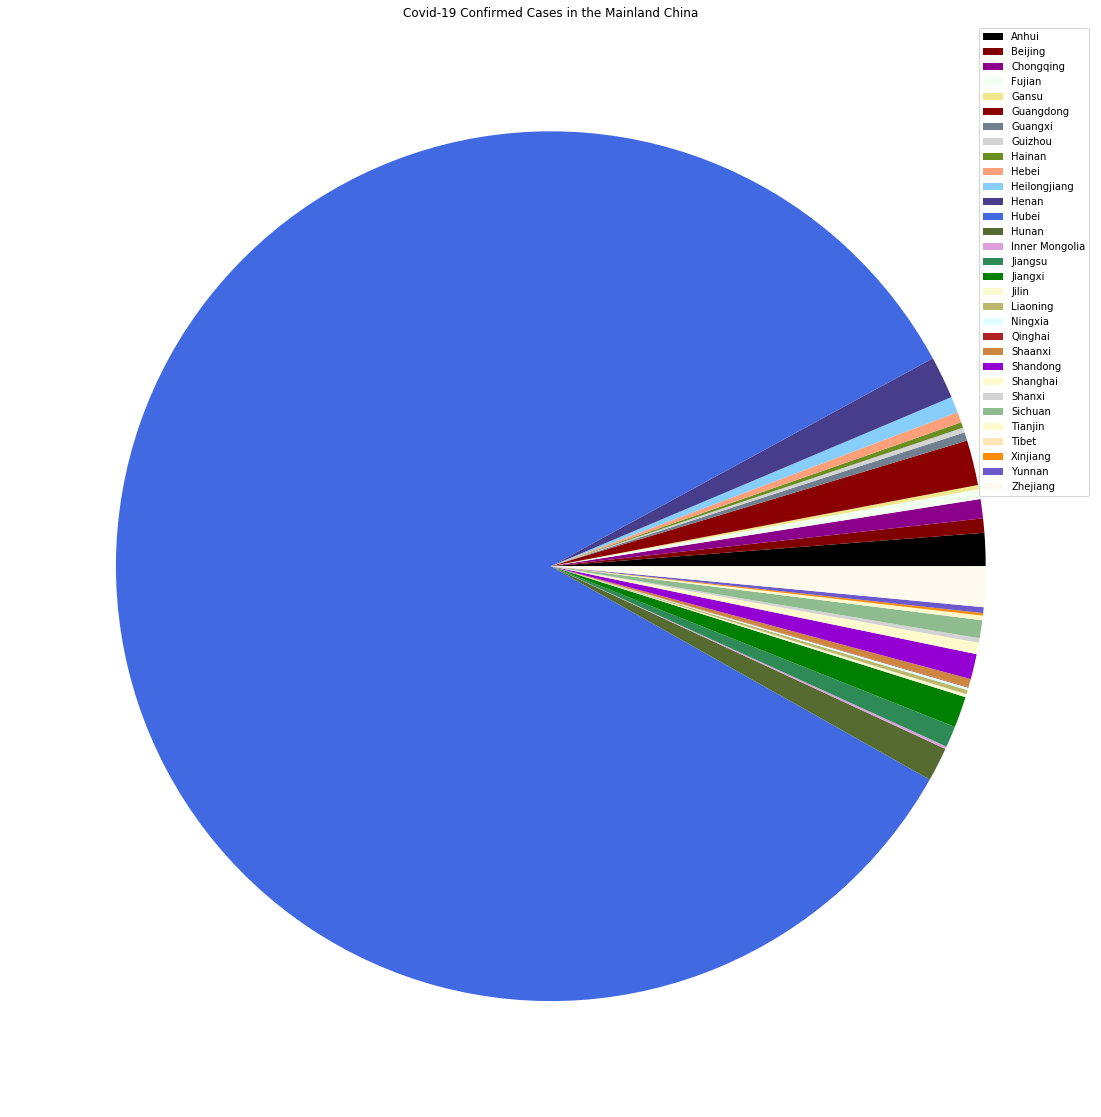

In [47]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the Mainland China')
plt.pie(china_confirmed_cases, colors=c)
plt.legend(china_regions, loc='best')
plt.show()